# Predicting change in bird conservation status with Neural Networks

##### Imports and files

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import sklearn
from keras import layers
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from IPython.display import display, Markdown
def md(s):
    display(Markdown(s))

In [3]:
dists = pd.read_csv("data/atlas_open_data_files/distributions.csv")
dist_changes = pd.read_csv("data/atlas_open_data_files/distribution_changes.csv")
grid_coords = pd.read_csv(
    "data/atlas_open_data_files/grid_square_coordinates_lookup.csv"
)
pct_bench_species = pd.read_csv(
    "data/atlas_open_data_files/percent_benchmark_species_detected.csv"
)
species_lookup = pd.read_csv(
    "data/atlas_open_data_files/species_lookup_nocase.csv", encoding="ISO-8859-1"
)
conservation_status = pd.read_csv("data/conservation/conservation_status_final.csv")

#### Misc stuff

In [4]:
# These are the top 10 birds which were spotted most in the Big Garden
# Birdwatch (2023) https://www.rspb.org.uk/whats-happening/big-garden-birdwatch
HOUSE_SPARROW = 459
BLUE_TIT = 436
STARLING = 457
WOODPIDGEON = 270
BLACKBIRD = 371
ROBIN = 345
GOLDFINCH = 471
GREAT_TIT = 437
MAGPIE = 450
LONG_TAILED_TIT = 431

# Predicting conservation status using citizen science bird atlases
- Do the BTO Birds of Conservation Concern lists reflect the change in bird distributions found in citizen science data?

[Classifications are from the BTO birds of conservation concern](https://www.bto.org/our-science/publications/birds-conservation-concern)

## Data preprocessing

### Conservation status
- Got atlas from Gillings et al.
- Got conservation status from BTO
- Only birds which have data in the atlas are included in study
- Formatted conservation status with atlas species lookup codes in CSV
- Corrected erroneous records where no species code was filled in caused by difference in bird names between lists
- The Great Auk went extinct in the 19th century -- there's no data for it in the atlases!
    - This record has been removed from the former breeding birds list
- Removed species aggregates from lookup
- Added latin names which serve as unique identifiers
- Eng names taken from species lookup

**The first red list was published in 1996.**

### Bird distribution data
- Problem: Different number of species studied in different atlases

In [5]:
dist_changes["interval"].unique()

array(['1970-2010', '1990-2010', '1980-2010', '1970-1990'], dtype=object)

In [6]:
# Which interval has the most birds in?
intervals = {"1970-2010": [], "1990-2010": [], "1980-2010": [], "1970-1990": []}

for i in intervals.keys():
    intervals[i].append(
        len(dist_changes[dist_changes["interval"] == i]["speccode"].unique())
    )

intervals

{'1970-2010': [300],
 '1990-2010': [316],
 '1980-2010': [414],
 '1970-1990': [278]}

In [7]:
# Group by "speccode" and "interval", and calculate the mean for each group
dist_changes_two_ints = dist_changes.query("interval == '1970-1990' or interval == '1990-2010'")
grouped = dist_changes_two_ints.groupby(["speccode", "interval"]).agg(
    {"n_tenkms_stable": "mean", "n_tenkms_gain": "mean", "n_tenkms_loss": "mean"}
)
grouped = grouped.reset_index()
grouped.columns = ["speccode", "interval", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss"]
dist_means = grouped
dist_means

speccode   interval  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss
0           1  1970-1990               0.63             0.27             0.10
1           1  1990-2010               0.60             0.16             0.24
2           2  1970-1990               0.51             0.22             0.26
3           2  1990-2010               0.54             0.26             0.20
4           3  1970-1990               0.02             0.87             0.11
..        ...        ...                ...              ...              ...
589      1578  1970-1990               0.00             0.00             1.00
590      1579  1970-1990               0.00             0.00             1.00
591      1583  1970-1990               0.76             0.07             0.17
592      1583  1990-2010               0.75             0.17             0.09
593      1584  1990-2010               0.00             1.00             0.00

[594 rows x 5 columns]

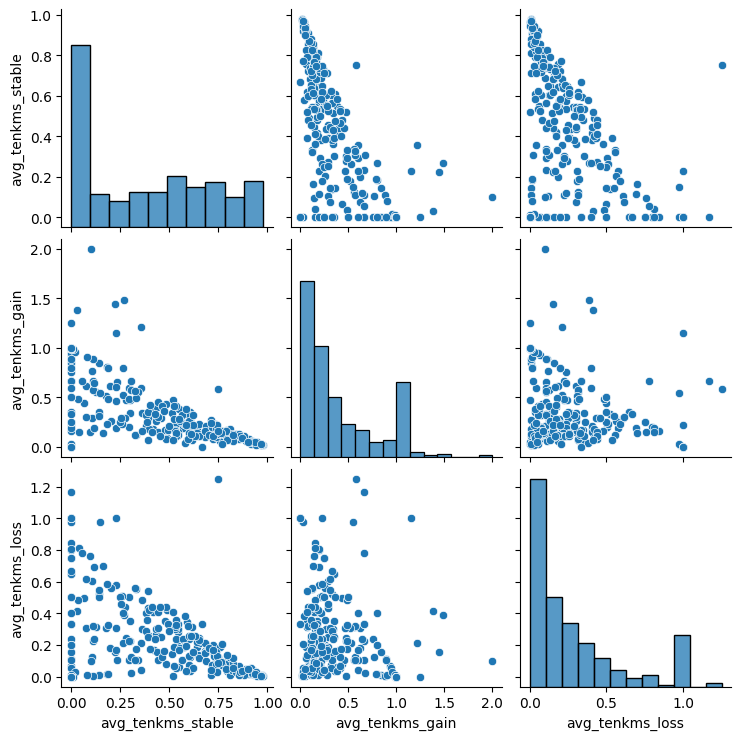

In [8]:
# Pairplot (useless?)
sample = sklearn.utils.resample(dist_means, n_samples=10)
ax = sns.pairplot(dist_means.query("interval == '1990-2010'")[["avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss"]])

### Readying labelled data for machine learning classifiers

In [9]:
cons_labels = conservation_status[["speccode", "status"]]
cons_labels = cons_labels[cons_labels["speccode"].isin(dist_means["speccode"])]
cons_labels

speccode status
0           1      g
1           2      a
2           3      a
5           6      g
6           7      g
..        ...    ...
448      1563      g
449      1569      g
452      1578      g
453      1579      g
455      1584      g

[319 rows x 2 columns]

#### Dataframe for machine learning

<table>
    <tr>
        <th>Column</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>speccode</td>
        <td>A unique number identifying a particular bird species.</td>
    </tr>
    <tr>
        <td>interval</td>
        <td>The period of time covered by the particular atlas.</td>
    </tr>
    <tr>
        <td colspan=3><strong>These columns represent averages over a 1-hot vector &#8212; that is, the proportion of 10km squares in which the species was detected or not at the beginning/end of the interval.</strong></td>
    </tr>
    <tr>
        <td>avg_tenkms_stable</td>
        <td>The proportion of 10km squares where the species was detected in at the beginning <strong>and</strong> end of the interval.</td>
    </tr>
    <tr>
        <td>avg_tenkms_gain</td>
        <td>The proportion of 10km squares where the species was detected at the end of the interval, but <strong>not</strong> the beginning.</td>
    </tr>
    <tr>
        <td>avg_tenkms_loss</td>
        <td>The proportion of 10km squares where the species was detected at the beginning of the interval, but <strong>not</strong> the end.</td>
    </tr>
    <tr>
        <td>status</td>
        <td>The conservation status of the species &#8212; Green, Amber, Red or Black (former breeding birds)</td>
    </tr>
</table>

In [10]:
dist_means_labelled = dist_means.merge(right=cons_labels, on="speccode")
dist_means_labelled

speccode   interval  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss  \
0           1  1970-1990               0.63             0.27             0.10   
1           1  1990-2010               0.60             0.16             0.24   
2           2  1970-1990               0.51             0.22             0.26   
3           2  1990-2010               0.54             0.26             0.20   
4           3  1970-1990               0.02             0.87             0.11   
..        ...        ...                ...              ...              ...   
583      1563  1970-1990               0.00             0.00             1.00   
584      1569  1970-1990               0.00             0.00             1.00   
585      1578  1970-1990               0.00             0.00             1.00   
586      1579  1970-1990               0.00             0.00             1.00   
587      1584  1990-2010               0.00             1.00             0.00   

    status  
0        g  
1        g  
2        a  
3        a  
4        a  
..     ...  
583      g  
584      g  
585      g  
586      g  
587      g  

[588 rows x 6 columns]

In [11]:
# Data on a few birds from the Red list
display(Markdown("Greenfinch ( *Cloris cloris* )"))
display(dist_means_labelled[dist_means_labelled["speccode"] == 470]) # greenfinch
display(Markdown("House sparrow ( *Passer domesticus* )"))
display(dist_means_labelled[dist_means_labelled["speccode"] == 459]) # house sparrow
display(Markdown("Tree sparrow ( *Passer montanus* )"))
display(dist_means_labelled[dist_means_labelled["speccode"] == 461]) # tree sparrow

Greenfinch ( *Cloris cloris* )

speccode   interval  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss  \
503       470  1970-1990               0.89             0.03             0.08   
504       470  1990-2010               0.88             0.11             0.01   

    status  
503      r  
504      r

House sparrow ( *Passer domesticus* )

speccode   interval  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss  \
493       459  1970-1990               0.93             0.00             0.06   
494       459  1990-2010               0.93             0.05             0.02   

    status  
493      r  
494      r

Tree sparrow ( *Passer montanus* )

speccode   interval  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss  \
495       461  1970-1990               0.66             0.09             0.25   
496       461  1990-2010               0.53             0.16             0.31   

    status  
495      r  
496      r

### Quick auto-assessment of various machine learning techniques
This automatic overview of various machine learning techniques on the individual values of avg_tenkms_stable, avg_tenkms_gain and avg_tenkms_loss, and 

In [12]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_loss"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
display(models)

100%|██████████| 29/29 [00:00<00:00, 43.80it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.214684
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -0.716243
[LightGBM] [Info] Start training from score -1.627872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.45               0.42    None      0.45   
LabelPropagation                   0.54               0.38    None      0.51   
LabelSpreading                     0.54               0.38    None      0.51   
SVC                                0.53               0.37    None      0.50   
LGBMClassifier                     0.50               0.36    None      0.48   
BernoulliNB                        0.49               0.35    None      0.40   
Perceptron                         0.49               0.35    None      0.40   
KNeighborsClassifier               0.48               0.33    None      0.45   
ExtraTreesClassifier               0.46               0.32    None      0.44   
RandomForestClassifier             0.45               0.32    None      0.44   
DecisionTreeClassifier             0.45               0.32    None      0.44   
AdaBoostClassifier                 0.43               0.32    None      0.41   
BaggingClassifier                  0.44               0.30    None      0.42   
ExtraTreeClassifier                0.43               0.30    None      0.41   
PassiveAggressiveClassifier        0.43               0.28    None      0.32   
CalibratedClassifierCV             0.43               0.27    None      0.31   
LinearDiscriminantAnalysis         0.43               0.27    None      0.31   
LinearSVC                          0.40               0.25    None      0.28   
LogisticRegression                 0.40               0.25    None      0.28   
RidgeClassifier                    0.40               0.25    None      0.28   
RidgeClassifierCV                  0.40               0.25    None      0.28   
GaussianNB                         0.41               0.25    None      0.24   
DummyClassifier                    0.41               0.25    None      0.24   
QuadraticDiscriminantAnalysis      0.41               0.25    None      0.24   
CategoricalNB                      0.41               0.25    None      0.24   
SGDClassifier                      0.41               0.25    None      0.24   

                               Time Taken  
Model                                      
NearestCentroid                      0.05  
LabelPropagation                     0.01  
LabelSpreading                       0.01  
SVC                                  0.01  
LGBMClassifier                       0.06  
BernoulliNB                          0.02  
Perceptron                           0.01  
KNeighborsClassifier                 0.02  
ExtraTreesClassifier                 0.07  
RandomForestClassifier               0.11  
DecisionTreeClassifier               0.01  
AdaBoostClassifier                   0.09  
BaggingClassifier                    0.02  
ExtraTreeClassifier                  0.01  
PassiveAggressiveClassifier          0.01  
CalibratedClassifierCV               0.04  
LinearDiscriminantAnalysis           0.01  
LinearSVC                            0.01  
LogisticRegression                   0.01  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.01  
GaussianNB                           0.01  
DummyClassifier                      0.01  
QuadraticDiscriminantAnalysis        0.01  
CategoricalNB                        0.01  
SGDClassifier                        0.01

In [13]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_gain"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 50.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.126392
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -0.744681
[LightGBM] [Info] Start training from score -1.700192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.36               0.42    None      0.31   
AdaBoostClassifier                 0.50               0.36    None      0.45   
GaussianNB                         0.49               0.33    None      0.46   
Perceptron                         0.41               0.33    None      0.37   
PassiveAggressiveClassifier        0.40               0.33    None      0.35   
QuadraticDiscriminantAnalysis      0.48               0.33    None      0.45   
KNeighborsClassifier               0.46               0.32    None      0.44   
LGBMClassifier                     0.49               0.32    None      0.44   
LabelSpreading                     0.46               0.32    None      0.38   
RandomForestClassifier             0.47               0.32    None      0.45   
ExtraTreesClassifier               0.46               0.31    None      0.44   
DecisionTreeClassifier             0.46               0.31    None      0.44   
LabelPropagation                   0.45               0.30    None      0.38   
ExtraTreeClassifier                0.46               0.30    None      0.44   
BaggingClassifier                  0.45               0.30    None      0.44   
SGDClassifier                      0.30               0.27    None      0.23   
DummyClassifier                    0.45               0.25    None      0.28   
BernoulliNB                        0.45               0.25    None      0.28   
SVC                                0.39               0.24    None      0.30   
LogisticRegression                 0.38               0.23    None      0.28   
RidgeClassifierCV                  0.38               0.23    None      0.28   
LinearSVC                          0.36               0.22    None      0.27   
RidgeClassifier                    0.36               0.22    None      0.27   
CalibratedClassifierCV             0.35               0.22    None      0.27   
LinearDiscriminantAnalysis         0.34               0.21    None      0.26   

                               Time Taken  
Model                                      
NearestCentroid                      0.01  
AdaBoostClassifier                   0.07  
GaussianNB                           0.01  
Perceptron                           0.01  
PassiveAggressiveClassifier          0.01  
QuadraticDiscriminantAnalysis        0.01  
KNeighborsClassifier                 0.01  
LGBMClassifier                       0.05  
LabelSpreading                       0.01  
RandomForestClassifier               0.13  
ExtraTreesClassifier                 0.07  
DecisionTreeClassifier               0.01  
LabelPropagation                     0.01  
ExtraTreeClassifier                  0.01  
BaggingClassifier                    0.02  
SGDClassifier                        0.01  
DummyClassifier                      0.01  
BernoulliNB                          0.01  
SVC                                  0.01  
LogisticRegression                   0.01  
RidgeClassifierCV                    0.01  
LinearSVC                            0.01  
RidgeClassifier                      0.01  
CalibratedClassifierCV               0.04  
LinearDiscriminantAnalysis           0.01

In [14]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_stable"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 55.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.245937
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -0.744681
[LightGBM] [Info] Start training from score -1.517871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.17               0.37    None      0.16   
LGBMClassifier                     0.54               0.35    None      0.49   
AdaBoostClassifier                 0.50               0.32    None      0.46   
BaggingClassifier                  0.50               0.32    None      0.48   
ExtraTreeClassifier                0.49               0.32    None      0.46   
RandomForestClassifier             0.49               0.31    None      0.47   
ExtraTreesClassifier               0.49               0.31    None      0.47   
DecisionTreeClassifier             0.49               0.31    None      0.47   
SVC                                0.52               0.31    None      0.42   
LabelSpreading                     0.51               0.30    None      0.40   
LabelPropagation                   0.50               0.30    None      0.40   
PassiveAggressiveClassifier        0.47               0.30    None      0.41   
KNeighborsClassifier               0.47               0.29    None      0.42   
Perceptron                         0.44               0.27    None      0.38   
QuadraticDiscriminantAnalysis      0.44               0.25    None      0.33   
RidgeClassifierCV                  0.44               0.25    None      0.33   
SGDClassifier                      0.44               0.25    None      0.33   
GaussianNB                         0.44               0.25    None      0.33   
BernoulliNB                        0.45               0.25    None      0.28   
DummyClassifier                    0.45               0.25    None      0.28   
LinearDiscriminantAnalysis         0.43               0.25    None      0.33   
RidgeClassifier                    0.43               0.25    None      0.32   
CalibratedClassifierCV             0.41               0.24    None      0.32   
LinearSVC                          0.41               0.24    None      0.32   
LogisticRegression                 0.41               0.24    None      0.32   

                               Time Taken  
Model                                      
NearestCentroid                      0.01  
LGBMClassifier                       0.04  
AdaBoostClassifier                   0.07  
BaggingClassifier                    0.02  
ExtraTreeClassifier                  0.01  
RandomForestClassifier               0.10  
ExtraTreesClassifier                 0.07  
DecisionTreeClassifier               0.01  
SVC                                  0.01  
LabelSpreading                       0.01  
LabelPropagation                     0.01  
PassiveAggressiveClassifier          0.01  
KNeighborsClassifier                 0.01  
Perceptron                           0.01  
QuadraticDiscriminantAnalysis        0.01  
RidgeClassifierCV                    0.01  
SGDClassifier                        0.01  
GaussianNB                           0.01  
BernoulliNB                          0.01  
DummyClassifier                      0.01  
LinearDiscriminantAnalysis           0.01  
RidgeClassifier                      0.01  
CalibratedClassifierCV               0.03  
LinearSVC                            0.01  
LogisticRegression                   0.01

### Neural Network approach - the first try
**WHY NEURAL NETWORKS?**
#### Inputs & outputs
||Shape|Form|
|-|-|-|
|Input|(6,)|$(avg\_stable_{1970-1990}, avg\_gain_{1970-1990}, avg\_loss_{1970-1990}, avg\_stable_{1990-2010}, avg\_gain_{1990-2010}, avg\_loss_{1990-2010})$|
|Output|(4,)|$(P(red), P(amber), P(green), P(black))$|

#### Network architecture
<img src="images/nn_1_arch.svg?1" width="40%" height="40%"></img>

#### Data preprocessing

In [15]:
# Arranging data for neural network use
# TODO make dataset the insersection of bird types between them
dist_means_labelled_1970 = dist_means_labelled.query("interval == '1970-1990'")
dist_means_labelled_1990 = dist_means_labelled.query("interval == '1990-2010'")
dist_means_labelled_1970

speccode   interval  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss  \
0           1  1970-1990               0.63             0.27             0.10   
2           2  1970-1990               0.51             0.22             0.26   
4           3  1970-1990               0.02             0.87             0.11   
6           6  1970-1990               0.55             0.16             0.28   
8           7  1970-1990               0.61             0.25             0.14   
..        ...        ...                ...              ...              ...   
581      1359  1970-1990               0.00             1.00             0.00   
583      1563  1970-1990               0.00             0.00             1.00   
584      1569  1970-1990               0.00             0.00             1.00   
585      1578  1970-1990               0.00             0.00             1.00   
586      1579  1970-1990               0.00             0.00             1.00   

    status  
0        g  
2        a  
4        a  
6        g  
8        g  
..     ...  
581      g  
583      g  
584      g  
585      g  
586      g  

[275 rows x 6 columns]

In [16]:
# These dataframes only contain data about birds which appear in both atlases
dist_1970_intersection = dist_means_labelled_1970[
    dist_means_labelled_1970["speccode"].isin(dist_means_labelled_1990["speccode"])
][["speccode", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss", "status"]]
dist_1990_intersection = dist_means_labelled_1990[
    dist_means_labelled_1990["speccode"].isin(dist_means_labelled_1970["speccode"])
][["speccode", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss", "status"]]
dist_1990_intersection

speccode  avg_tenkms_stable  avg_tenkms_gain  avg_tenkms_loss status
1           1               0.60             0.16             0.24      g
3           2               0.54             0.26             0.20      a
5           3               0.00             0.02             0.98      a
7           6               0.56             0.33             0.11      g
9           7               0.65             0.22             0.13      g
..        ...                ...              ...              ...    ...
565      1215               0.00             0.60             0.40      g
571      1288               0.00             0.99             0.01      g
575      1293               0.00             0.89             0.11      g
577      1294               0.00             0.00             1.00      g
582      1359               0.00             0.00             1.00      g

[269 rows x 5 columns]

**There are 269 bird species that are covered in both atlases.**

In [17]:
X = np.array(
    [
        (
            dml_1970[1],
            dml_1970[2],
            dml_1970[3],
            dml_1990[1],
            dml_1990[2],
            dml_1990[3],
        )
        for (dml_1970, dml_1990) in zip(
            dist_1970_intersection.to_numpy(), dist_1990_intersection.to_numpy()
        )
    ]
)
X.shape

(269, 6)

In [18]:
y = np.array(
    [
        (
            1 if i[-1] == "g" else 0, # green
            1 if i[-1] == "a" else 0, # amber
            1 if i[-1] == "r" else 0, # red
            1 if i[-1] == "b" else 0, # black (former breeding)
        )
        for i in dist_1970_intersection.to_numpy()
    ]
)
y.shape

(269, 4)

#### Train & evaluate with conventional hyperparams

##### Training, fitting and predicting

In [19]:
# Hyperparameters
TRAIN_SIZE = 0.20
BATCH_SIZE = 20
EPOCHS = 250
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [20]:
# This data is stratified by default!
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)

In [21]:
base_model = keras.Sequential(
    [
        layers.Dense(units=8, activation="relu", input_shape=(6,)),
        layers.Dense(units=8, activation="relu"),
        layers.Dense(units=4),
    ]
)

In [22]:
base_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=METRICS,
)

In [27]:
base_history = base_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)
base_model.save_weights("checkpoints/base_model")

Epoch 1/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1284 - cross entropy: 0.3884 - Brier score: 0.1284 - tp: 18.0000 - fp: 7.0000 - tn: 152.0000 - fn: 35.0000 - accuracy: 0.8019 - precision: 0.7200 - recall: 0.3396 - auc: 0.8715 - prc: 0.6746
Epoch 2/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1283 - cross entropy: 0.3881 - Brier score: 0.1283 - tp: 18.0000 - fp: 7.0000 - tn: 152.0000 - fn: 35.0000 - accuracy: 0.8019 - precision: 0.7200 - recall: 0.3396 - auc: 0.8723 - prc: 0.6766
Epoch 3/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1281 - cross entropy: 0.3877 - Brier score: 0.1281 - tp: 18.0000 - fp: 7.0000 - tn: 152.0000 - fn: 35.0000 - accuracy: 0.8019 - precision: 0.7200 - recall: 0.3396 - auc: 0.8723 - prc: 0.6777
Epoch 4/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1281 - cross entropy: 0.3877 - Brier score: 0.1281 - tp: 19.0000 - fp: 7.0000 - tn: 152.0000 - fn: 34.0000 - accuracy: 0.8066 - precisi

Epoch 5/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1279 - cross entropy: 0.3871 - Brier score: 0.1279 - tp: 21.0000 - fp: 8.0000 - tn: 151.0000 - fn: 32.0000 - accuracy: 0.8113 - precision: 0.7241 - recall: 0.3962 - auc: 0.8715 - prc: 0.6738
Epoch 6/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1278 - cross entropy: 0.3868 - Brier score: 0.1278 - tp: 21.0000 - fp: 8.0000 - tn: 151.0000 - fn: 32.0000 - accuracy: 0.8113 - precision: 0.7241 - recall: 0.3962 - auc: 0.8724 - prc: 0.6761
Epoch 7/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1277 - cross entropy: 0.3868 - Brier score: 0.1277 - tp: 20.0000 - fp: 8.0000 - tn: 151.0000 - fn: 33.0000 - accuracy: 0.8066 - precision: 0.7143 - recall: 0.3774 - auc: 0.8726 - prc: 0.6747
Epoch 8/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1276 - cross entropy: 0.3864 - Brier score: 0.1276 - tp: 20.0000 - fp: 8.0000 - tn: 151.0000 - fn: 33.0000 - accuracy: 0.8066 - precisi

##### Evaluation of results

Accuracy is not a suitable metric for this dataset as it's very imbalanced.

In [47]:
base_results = base_model.evaluate(X, y, batch_size=BATCH_SIZE)
md("### Metrics rundown")
md(f"True positives $-$ e.g. a bird who **is** Red *correctly* predicted as Red: **{int(base_results[3])}**")
md(f"False positives $-$ e.g. a bird who is **not** Red *incorrectly* predicted as Red: **{int(base_results[4])}**")
md(f"True negatives $-$ e.g. a bird who is **not** Red *correctly* predicted as something else: **{int(base_results[5])}**")
md(f"False negatives $-$ e.g. a bird who **is** red *incorrectly* predicted as something else: **{int(base_results[6])}**")

 1/14 [=>............................] - ETA: 0s - loss: 0.1929 - cross entropy: 0.6510 - Brier score: 0.1929 - tp: 6.0000 - fp: 5.0000 - tn: 55.0000 - fn: 14.0000 - accuracy: 0.7625 - precision: 0.5455 - recall: 0.3000 - auc: 0.7958 - prc: 0.5088

14/14 [==============================] - 0s 4ms/step - loss: 0.1782 - cross entropy: 0.7749 - Brier score: 0.1782 - tp: 119.0000 - fp: 112.0000 - tn: 695.0000 - fn: 150.0000 - accuracy: 0.7565 - precision: 0.5152 - recall: 0.4424 - auc: 0.7795 - prc: 0.4883


### Metrics rundown

True positives $-$ e.g. a bird who **is** Red *correctly* predicted as Red: **119**

False positives $-$ e.g. a bird who is **not** Red *incorrectly* predicted as Red: **112**

True negatives $-$ e.g. a bird who is **not** Red *correctly* predicted as something else: **695**

False negatives $-$ e.g. a bird who **is** red *incorrectly* predicted as something else: **150**

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 2ms/step


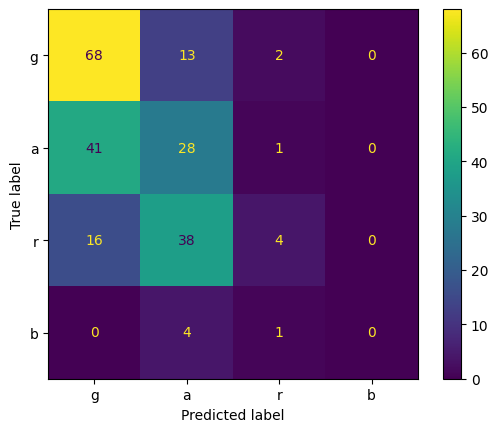

In [51]:
# Confusion matrix
y_predict = base_model.predict(X_test)
y_predict_max = np.array([
    np.argmax(i) for i in y_predict
])

# Convert one-hot encoded y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix
confusion = sklearn.metrics.confusion_matrix(y_test_labels, y_predict_max)
confusion_matrix = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=["g", "a", "r", "b"]).plot()

In [30]:
dist_1970_intersection["status"].value_counts()

status
g    108
a     88
r     68
b      5
Name: count, dtype: int64

This model is basically just guessing based on which category shows up the most!

#### Problems with this approach

- There's so many more birds in the Green list that the model just learns to guess green, and it'll be right half the time.
- The sample was stratified by default as `train_test_split` does $-$ there just wasn't enough birds in the dataset

### Does oversampling improve classification?